✅ Downloaded data for PHM
✅ Downloaded data for TOL


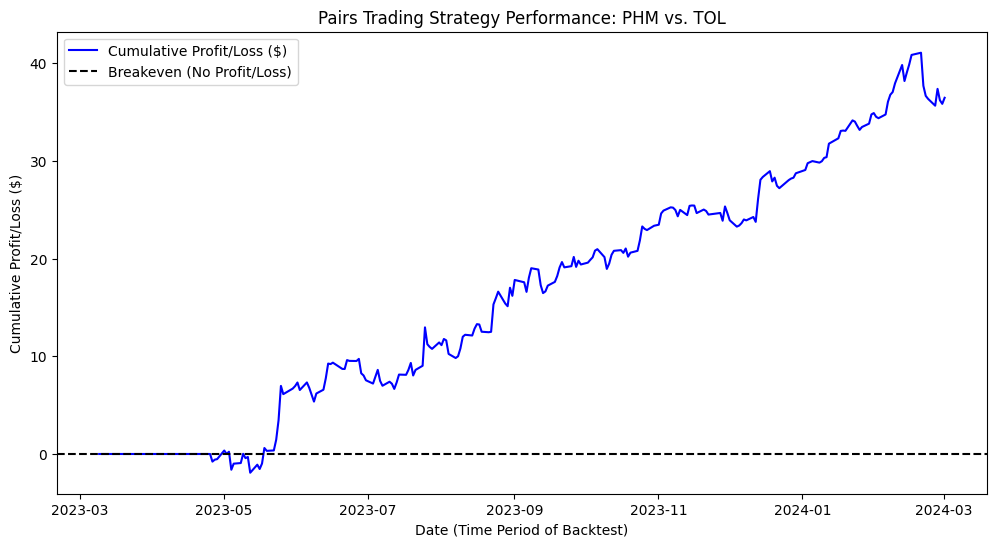

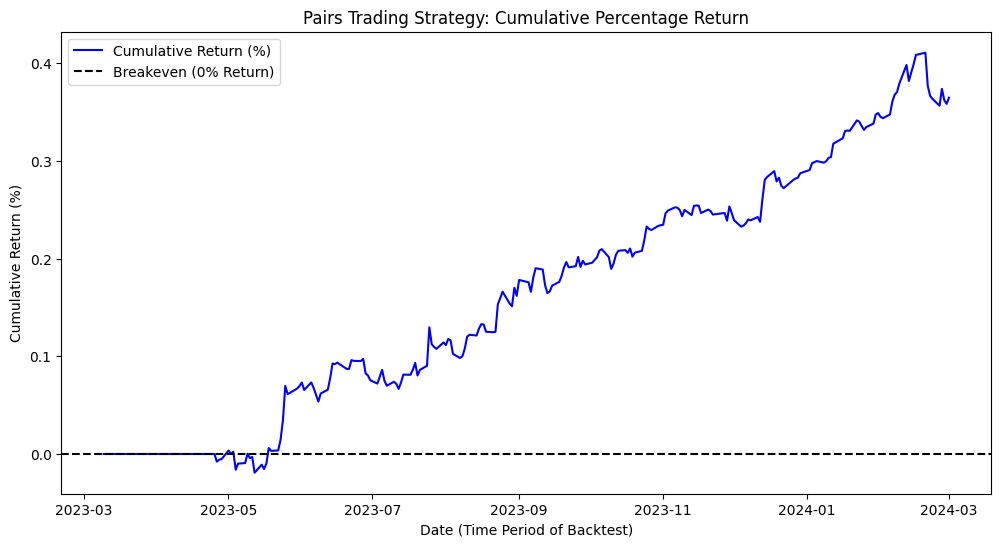

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from polygon import RESTClient
import time

API_KEY = "mEqEtplJt3hKWsHJpWQnTKBQJGjcruSx"

client = RESTClient(API_KEY)

tickers = ["PHM", "TOL"]
start_date = "2023-03-01"
end_date = "2024-03-01"

data_dict = {}

for ticker in tickers:
    try:
        bars = client.get_aggs(ticker=ticker, multiplier=1, timespan="day", from_=start_date, to=end_date)
        df = pd.DataFrame(bars)
        df["date"] = pd.to_datetime(df["timestamp"], unit="ms")  
        df.set_index("date", inplace=True)
        data_dict[ticker] = df["close"]
        print(f"✅ Downloaded data for {ticker}")
        time.sleep(1) 
    except Exception as e:
        print(f"❌ Failed to download {ticker}: {e}")

data = pd.DataFrame(data_dict)

data.head()

stock1, stock2 = "PHM", "TOL"

spread = data[stock1] - data[stock2]

rolling_mean = spread.rolling(window=30).mean()
rolling_std = spread.rolling(window=30).std()

z_score = (spread - rolling_mean) / rolling_std

signals = pd.DataFrame(index=data.index)
signals["Spread"] = spread
signals["Z-Score"] = z_score

signals["Long Entry"] = z_score < -2   # Buy PHM, Sell TOL
signals["Short Entry"] = z_score > 2   # Sell PHM, Buy TOL
signals["Exit"] = (z_score > -0.5) & (z_score < 0.5)  # Close position

signals["Position"] = 0

signals.loc[signals["Long Entry"], "Position"] = 1
signals.loc[signals["Short Entry"], "Position"] = -1

signals.loc[signals["Exit"], "Position"] = 0

signals["Position"] = signals["Position"].replace(0, np.nan).ffill().fillna(0)

returns_stock1 = data[stock1].pct_change()
returns_stock2 = data[stock2].pct_change()

signals["Strategy Returns"] = signals["Position"].shift(1) * (returns_stock1 - returns_stock2) * 100  # 100 shares

signals["Cumulative PnL"] = signals["Strategy Returns"].cumsum()

plt.figure(figsize=(12, 6))

# Plot cumulative PnL
plt.plot(signals["Cumulative PnL"], label="Cumulative Profit/Loss ($)", color="blue")
plt.axhline(0, color="black", linestyle="--", label="Breakeven (No Profit/Loss)")

# Labels & title
plt.xlabel("Date (Time Period of Backtest)")
plt.ylabel("Cumulative Profit/Loss ($)")
plt.title("Pairs Trading Strategy Performance: PHM vs. TOL")
plt.legend()

# Show plot
plt.show()

signals["Percent Return"] = (signals["Cumulative PnL"] / 10000) * 100

# Plot percentage return over time
plt.figure(figsize=(12, 6))
plt.plot(signals.index, signals["Percent Return"], label="Cumulative Return (%)", color="blue")
plt.axhline(0, color="black", linestyle="--", label="Breakeven (0% Return)")

# Labels & title
plt.xlabel("Date (Time Period of Backtest)")
plt.ylabel("Cumulative Return (%)")
plt.title("Pairs Trading Strategy: Cumulative Percentage Return")
plt.legend()

# Show plot
plt.show()


✅ Downloaded data for PHM
✅ Downloaded data for TOL


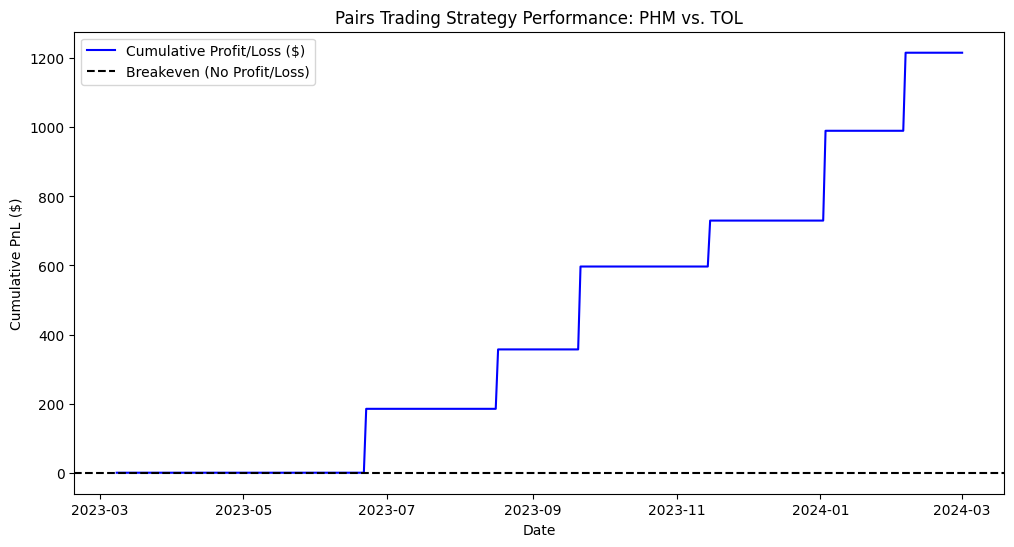

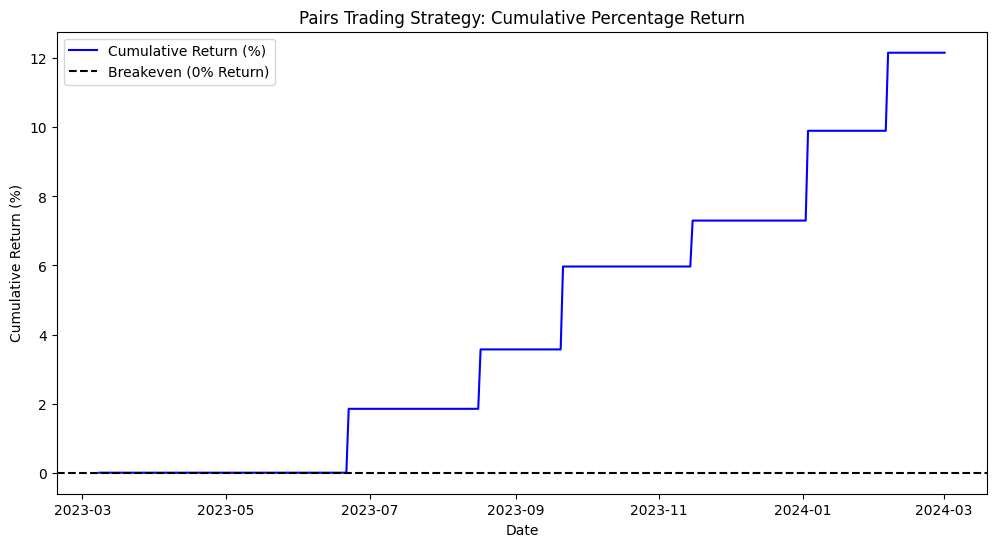

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from polygon import RESTClient
import time

# Polygon.io API Key
API_KEY = "mEqEtplJt3hKWsHJpWQnTKBQJGjcruSx"
client = RESTClient(API_KEY)

# Define tickers and date range
tickers = ["PHM", "TOL"]
start_date = "2023-03-01"
end_date = "2024-03-01"

# Fetch stock data
data_dict = {}
for ticker in tickers:
    try:
        bars = client.get_aggs(ticker=ticker, multiplier=1, timespan="day", from_=start_date, to=end_date)
        df = pd.DataFrame(bars)
        df["date"] = pd.to_datetime(df["timestamp"], unit="ms")
        df.set_index("date", inplace=True)
        data_dict[ticker] = df["close"]
        print(f"✅ Downloaded data for {ticker}")
        time.sleep(1)  # Avoid API rate limits
    except Exception as e:
        print(f"❌ Failed to download {ticker}: {e}")

# Create DataFrame
data = pd.DataFrame(data_dict)

# Define stock pair
stock1, stock2 = "PHM", "TOL"

# Compute spread, rolling mean, and Z-score
spread = data[stock1] - data[stock2]
rolling_mean = spread.rolling(window=30).mean()
rolling_std = spread.rolling(window=30).std()
z_score = (spread - rolling_mean) / rolling_std

# Initialize signals DataFrame
signals = pd.DataFrame(index=data.index)
signals["Spread"] = spread
signals["Z-Score"] = z_score

# Define trading signals
signals["Long Entry"] = z_score < -2  # Buy PHM, Sell TOL
signals["Short Entry"] = z_score > 2  # Sell PHM, Buy TOL
signals["Exit"] = (z_score > -0.2) & (z_score < 0.2)  # Close position

# Define position tracking
signals["Position"] = 0
signals.loc[signals["Long Entry"], "Position"] = 1
signals.loc[signals["Short Entry"], "Position"] = -1
signals.loc[signals["Exit"], "Position"] = 0
signals["Position"] = signals["Position"].replace(0, np.nan).ffill().fillna(0)

# Define trading size
initial_capital = 10000
position_size = 100  # Trading 100 shares per stock

# Track trade PnL
signals["Trade PnL"] = 0.0
entry_price = None
position = 0

for i in range(1, len(signals)):
    if signals["Long Entry"].iloc[i]:  # Long Spread (Buy PHM, Sell TOL)
        position = 1
        entry_price = spread.iloc[i]

    elif signals["Short Entry"].iloc[i]:  # Short Spread (Sell PHM, Buy TOL)
        position = -1
        entry_price = spread.iloc[i]

    elif signals["Exit"].iloc[i] and position != 0:  # Close Position
        exit_price = spread.iloc[i]
        trade_pnl = position * (exit_price - entry_price) * position_size  # PnL per 100 shares
        signals.loc[signals.index[i], "Trade PnL"] = trade_pnl
        position = 0  # Reset position

# Compute cumulative PnL
signals["Cumulative PnL"] = signals["Trade PnL"].cumsum()

# Compute percentage return
signals["Percent Return"] = (signals["Cumulative PnL"] / initial_capital) * 100

# Plot updated Cumulative PnL
plt.figure(figsize=(12, 6))
plt.plot(signals["Cumulative PnL"], label="Cumulative Profit/Loss ($)", color="blue")
plt.axhline(0, color="black", linestyle="--", label="Breakeven (No Profit/Loss)")
plt.xlabel("Date")
plt.ylabel("Cumulative PnL ($)")
plt.title("Pairs Trading Strategy Performance: PHM vs. TOL")
plt.legend()
plt.show()

# Plot updated Percentage Return
plt.figure(figsize=(12, 6))
plt.plot(signals.index, signals["Percent Return"], label="Cumulative Return (%)", color="blue")
plt.axhline(0, color="black", linestyle="--", label="Breakeven (0% Return)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (%)")
plt.title("Pairs Trading Strategy: Cumulative Percentage Return")
plt.legend()
plt.show()